In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from utils import get_data
price_col = 'd_ln_open_price'
# price_col = 'ln_open_price'

results_df = None

from sklearn.preprocessing import MinMaxScaler

def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency', 'cost', 'open_price']])
    normalized_count = normalized_values[:, 0]
    normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    normalized_cost = normalized_values[:, 2]
    normalized_open_price = normalized_values[:, 3]

    offset = -9 if price_col == 'ln_open_price' else 0
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data[price_col]+offset, label=f'Actual {price_col}', color='blue', marker='o')
    plt.scatter(test_data.index, predictions+offset, label=f'Predicted {price_col}', color='red', marker='x')
    plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    plt.plot(test_data.index, normalized_cost, label='Normalized Cost', color='orange', linestyle=':')
    plt.plot(test_data.index, normalized_open_price, label='Normalized Open Price', color='black', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def get_stats(model_fit, predictions, test_data):
    mae = mean_absolute_error(test_data[price_col], predictions)
    mse = mean_squared_error(test_data[price_col], predictions)
    rmse = np.sqrt(mse)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = [-1,-1]
    try:
        white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    except Exception as e:
        pass
    
    return {
        'MAE':mae,
        'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }

# Adjust the model estimation to use the differenced series
def model_estimation(data, p_range, q_range, title='Model Estimation', eval_size=8):
    global results_df
    
    # Baseline 3: no exog
    # use_exog = False
    use_exog = True

    results = []
    data_size = len(data)
    train_size = data_size - eval_size

    cols = [
        'd_cost',
        "d_posts_count", 
        # "d_bitcoin_adoption", 
        "d_pessimistic_speculation", 
        "d_optimistic_speculation"
        ]

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                rolling_mse = []
                mean_baseline_mae = []
                mean_baseline_mse = []
                prev_value_baseline_mae = []
                prev_value_baseline_mse = []
                step_size = 1
                summary = ""
                for end in range(train_size, data_size, step_size):  # Adjust these values as needed
                    print(f"p: {p}, q: {q}, end: {end}")
                    rolling_train = data.iloc[0:end]
                    rolling_test = data.iloc[end:end + step_size]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[cols], rolling_test[cols])
                    
                    # Baseline 1: Mean Prediction
                    mean_pred = np.mean(rolling_train[price_col])
                    mean_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [mean_pred]*step_size))
                    mean_baseline_mse.append(mean_squared_error(rolling_test[price_col], [mean_pred]*step_size))
                    
                    # Baseline 2: Previous Value Prediction
                    prev_value_pred = rolling_train[price_col].iloc[-1]
                    prev_value_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [prev_value_pred]*step_size))
                    prev_value_baseline_mse.append(mean_squared_error(rolling_test[price_col], [prev_value_pred]*step_size))


                    # ARIMA Model
                    if use_exog:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q), exog=rolling_train_exog)
                    else:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q))
                    model_fit = model.fit()
                    
                    summary = model_fit.summary()
                    if use_exog:
                        predictions = model_fit.forecast(steps=step_size, exog=rolling_test_exog)
                    else:
                        predictions = model_fit.forecast(steps=step_size)
                    mae = mean_absolute_error(rolling_test[price_col], predictions)
                    mse = mean_squared_error(rolling_test[price_col], predictions)
                    rolling_mae.append(mae)
                    rolling_mse.append(mse)
                
                print("rolling_mse")
                print(rolling_mse)
                avg_mae = np.mean(rolling_mae)
                avg_mse = np.mean(rolling_mse)
                avg_mean_baseline_mae = np.mean(mean_baseline_mae)
                avg_mean_baseline_mse = np.mean(mean_baseline_mse)
                avg_prev_value_baseline_mae = np.mean(prev_value_baseline_mae)
                avg_prev_value_baseline_mse = np.mean(prev_value_baseline_mse)
                results.append({'p': p, 'q': q, 'MAE': avg_mae, 'Mean Baseline MAE': avg_mean_baseline_mae, 'Prev Value Baseline MAE': avg_prev_value_baseline_mae, 'MSE': avg_mse, 'Mean Baseline MSE': avg_mean_baseline_mse, 'Prev Value Baseline MSE': avg_prev_value_baseline_mse,'Summary': summary,})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MSE'])
    print(f"Mean Baseline MSE: {results[0]['Mean Baseline MSE']}")
    print(f"Previous Value Baseline MSE: {results[0]['Prev Value Baseline MSE']}")
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        print(f"Top {i+1} Model: ARIMA({p},0,{q}), MSE: {results[i]['MSE']}")
        # Fit the model on the entire training dataset
        train_data = data.iloc[0:train_size]
        test_data = data.iloc[train_size:]
        if use_exog:
            train_exog, test_exog = add_constant(train_data[cols], test_data[cols])
            model = ARIMA(train_data[price_col], order=(p, 0, q), exog=train_exog)
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
        else:
            model = ARIMA(train_data[price_col], order=(p, 0, q))
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test_data))
        print(results[i]['Summary'])
        print(get_stats(model_fit, predictions, test_data))
        plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")



In [11]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    cols = [price_col,'cost'] #'d_ln_avg_efficiency', 
    numeric_df = df[cols]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # print(summary)

    for col in cols:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=10, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=10, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    # if result[1] > 0.05:
    #     print("Series is not stationary")
    # else:
    #     print("Series is stationary")


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    # return score, p_value, crit_value


def cross_correlation(series1, series2, lag=10, plot=True):
    """
    Calculate and plot cross-correlation between two series.
    
    Parameters:
    - series1: First time series.
    - series2: Second time series.
    - lag: Number of lags to calculate cross-correlation for.
    - plot: Whether to plot the cross-correlation values.
    
    Returns:
    - Cross-correlation values.
    """
    cc_values = [series1.corr(series2.shift(l)) for l in range(-lag, lag+1)]
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.stem(range(-lag, lag+1), cc_values)#, use_line_collection=True)
        plt.xlabel('Lag')
        plt.ylabel('Cross-correlation')
        plt.title('Cross-correlation between series')
        plt.show()
    
    return cc_values

In [12]:
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

In [13]:
quarterly_data.sample(10)

,avg_efficiency,max_efficiency,open_price,optimistic_speculation,pessimistic_speculation,bitcoin_adoption,bitcoin_technology,bitcoin_challenges,altcoins,educational_resources,posts_count,count,cost,time,ln_avg_efficiency,d_ln_avg_efficiency,ln_open_price,d_ln_open_price,d_cost,d_optimistic_speculation,d_pessimistic_speculation,d_bitcoin_adoption,d_posts_count
date,,,,,,,,,,,,,,,,,,,,,,,
2021-06-30,0.010540,0.033900,51244.597451,0.679593,0.540688,0.460843,0.271595,0.793639,0.561736,0.098987,0.103551,3.0,0.079417,125.0,-4.552558,-0.302478,10.844365,0.361172,-0.062371,-0.104280,0.135607,0.036169,-0.027377
2022-12-31,0.022901,0.046500,19028.392543,0.598122,0.374877,0.509473,0.313201,0.482881,0.290103,0.444670,0.078236,1.0,0.374701,143.0,-3.776595,0.726931,9.853687,-0.103149,0.092078,0.141486,-0.031914,0.052960,-0.000229
2017-03-31,0.002738,0.010200,1038.038667,0.151444,0.129199,0.261845,0.631712,0.868687,0.462267,0.181300,0.216151,7.0,0.125773,74.0,-5.900595,-0.543055,6.945088,0.414989,-0.009021,-0.005602,0.112008,-0.120977,0.103895
2016-06-30,0.001730,0.008160,465.477667,0.234216,0.081292,0.398717,0.580752,0.539803,0.403709,0.392412,0.141237,8.0,0.124416,65.0,-6.359815,-0.393589,6.143064,0.121207,-0.017472,0.112923,0.037229,0.126695,-0.030011
2023-09-30,0.016339,0.046500,28562.190000,0.752843,0.255193,0.423068,0.306772,0.437258,0.342335,0.482577,0.095189,3.0,0.341823,152.0,-4.114211,-0.525574,10.259839,0.009305,0.021064,0.180412,-0.007698,0.031731,-0.021535
2020-12-31,0.013992,0.033900,14754.641461,0.840518,0.357833,0.434239,0.317490,0.518590,0.311706,0.319988,0.127262,0.0,0.351022,119.0,-4.269246,-0.200130,9.599313,0.320622,0.022817,0.337027,0.174973,0.046283,0.048683
2015-06-30,0.001448,0.005350,236.853000,0.156820,0.087341,0.400519,0.597408,0.674464,0.455081,0.290958,0.143986,13.0,0.123647,53.0,-6.537316,0.076629,5.467440,-0.108408,0.012354,-0.061727,-0.090460,-0.095540,-0.022680
2018-09-30,0.008237,0.010847,7047.266731,0.661754,0.494512,0.475450,0.317848,0.593614,0.632327,0.180965,0.215120,17.0,0.167907,92.0,-4.799143,-0.065038,8.860395,-0.114937,0.057372,0.134587,-0.074715,0.120915,-0.070218
2018-03-31,0.008571,0.010210,11579.809375,0.536155,0.612999,0.302636,0.300059,0.634131,0.922842,0.233800,0.782932,12.0,0.056515,86.0,-4.759388,0.041325,9.357018,0.505122,0.004644,0.000508,0.146926,0.057734,-0.018099


# Quaterly

Quarterly Data Model Estimation:
p: 1, q: 1, end: 28
p: 1, q: 1, end: 29
p: 1, q: 1, end: 30


p: 1, q: 1, end: 31
p: 1, q: 1, end: 32
p: 1, q: 1, end: 33
p: 1, q: 1, end: 34
p: 1, q: 1, end: 35
rolling_mse
[0.08192508642976581, 0.059465931088891304, 0.04290732598328152, 0.005036589140594194, 0.002125985368639856, 3.923751187578465e-05, 0.014062007071907046, 0.2281672511671062]
p: 1, q: 2, end: 28
p: 1, q: 2, end: 29
p: 1, q: 2, end: 30
p: 1, q: 2, end: 31
p: 1, q: 2, end: 32
p: 1, q: 2, end: 33
p: 1, q: 2, end: 34
p: 1, q: 2, end: 35
rolling_mse
[0.11676257146639037, 0.13411626988712214, 0.05233726928244862, 0.009003166474499563, 0.00318406471736359, 6.628776775145563e-05, 0.013490779296963297, 0.2223441385093055]
p: 1, q: 3, end: 28
p: 1, q: 3, end: 29
p: 1, q: 3, end: 30
p: 1, q: 3, end: 31
p: 1, q: 3, end: 32
p: 1, q: 3, end: 33
p: 1, q: 3, end: 34
p: 1, q: 3, end: 35
rolling_mse
[0.13372908004395956, 0.13351610145623846, 0.041803038718347896, 0.0030467178303959183, 0.00014923760330945514, 0.02732575481077541, 0.013448074361304657, 0.23499912022375488]
p: 1, q: 4, end: 28
p:

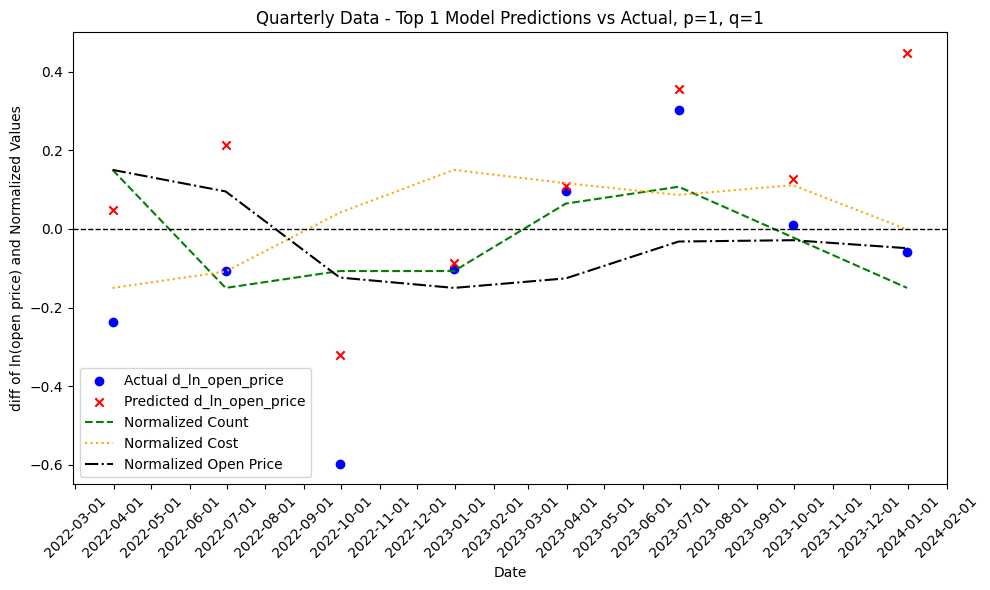

Top 2 Model: ARIMA(3,0,3), MSE: 0.057450992876511835
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                   35
Model:                 ARIMA(3, 0, 3)   Log Likelihood                  18.784
Date:                Sat, 30 Mar 2024   AIC                            -13.568
Time:                        14:07:22   BIC                              5.096
Sample:                    03-31-2015   HQIC                            -7.125
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1468      0.049      2.969      0.003       0.050       0.244
d_cost                       -3.3

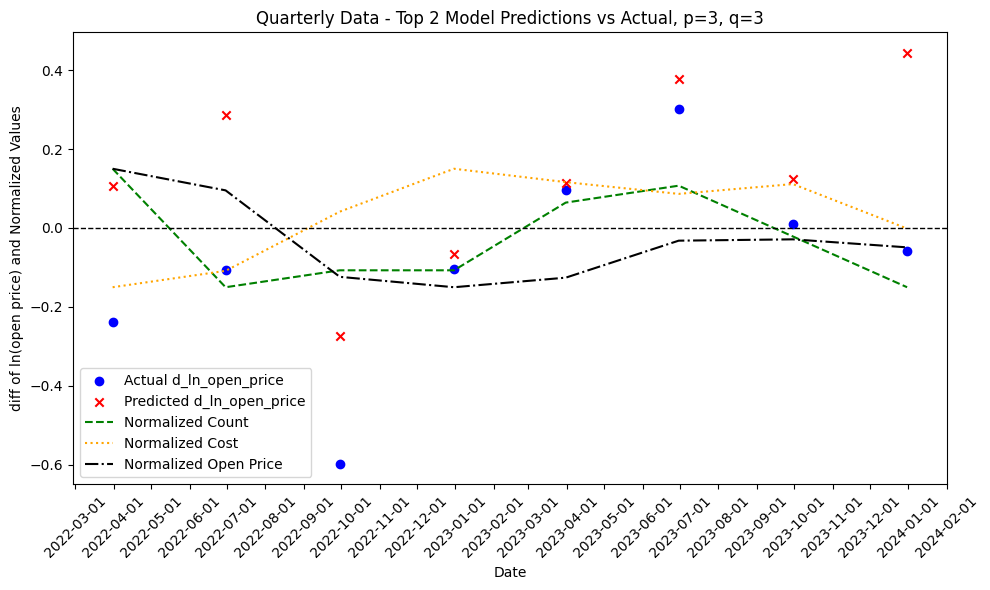

Top 3 Model: ARIMA(2,0,1), MSE: 0.06306467751244745
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                   35
Model:                 ARIMA(2, 0, 1)   Log Likelihood                  18.635
Date:                Sat, 30 Mar 2024   AIC                            -19.271
Time:                        14:07:13   BIC                             -5.273
Sample:                    03-31-2015   HQIC                           -14.439
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1509      0.037      4.056      0.000       0.078       0.224
d_cost                       -3.24

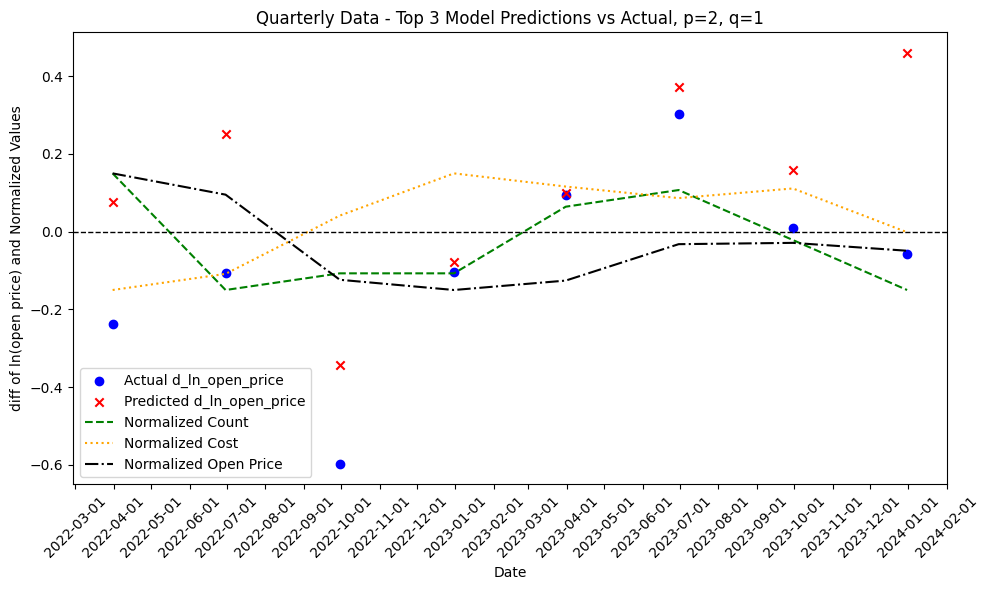

In [14]:
print("Quarterly Data Model Estimation:")
model_estimation(quarterly_data, range(1, 5, 1), range(1, 5, 1), title='Quarterly Data', eval_size=8)
results_df

In [14]:
print(f"Stationarity check for d_ln_open_price:")
check_stationarity(quarterly_data['d_ln_open_price'])
print(f"\nStationarity check for ln_open_price:")
check_stationarity(quarterly_data['ln_open_price'])
print("\nStationarity check for d_ln_avg_efficiency:")
check_stationarity(quarterly_data['d_ln_avg_efficiency'])
print("\nStationarity check for cost:")
check_stationarity(quarterly_data['cost'])
print("\nStationarity check for d_cost:")
check_stationarity(quarterly_data['d_cost'])

Stationarity check for d_ln_open_price:
ADF Statistic: -3.826154
p-value: 0.002651

Stationarity check for ln_open_price:
ADF Statistic: -1.948507
p-value: 0.309597

Stationarity check for d_ln_avg_efficiency:
ADF Statistic: -9.975397
p-value: 0.000000

Stationarity check for cost:
ADF Statistic: -3.001360
p-value: 0.034768

Stationarity check for d_cost:
ADF Statistic: -4.809379
p-value: 0.000052


Distribution Plot:


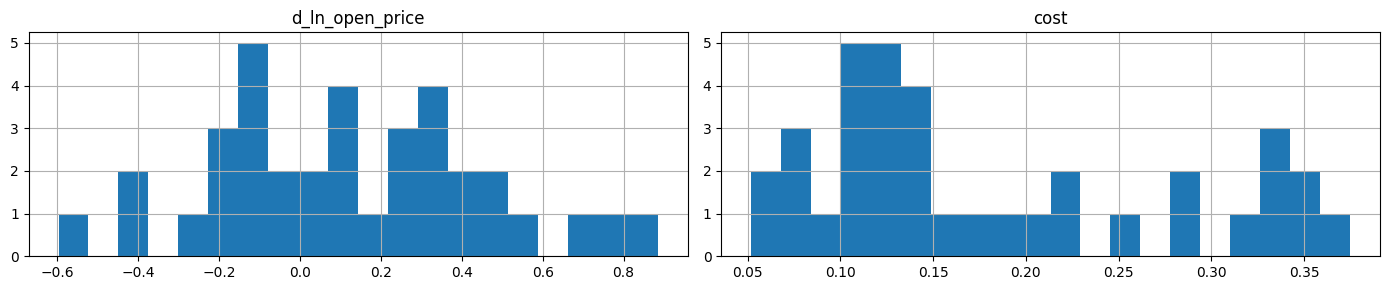

Summary Statistics:
ACF and PACF Plots for d_ln_open_price:


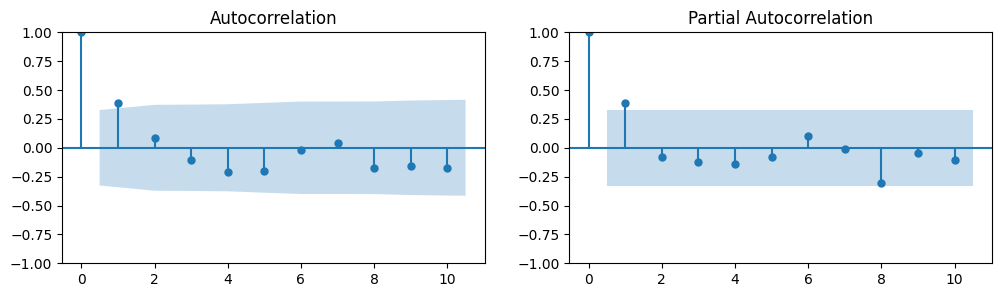

ACF and PACF Plots for cost:


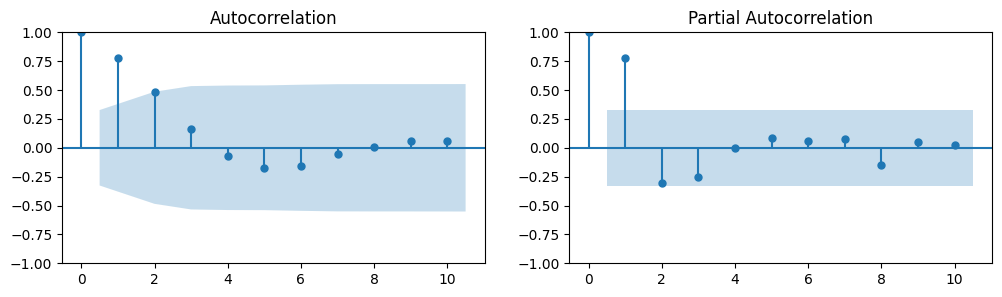

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_open_price,36.0,0.125502,0.342327,-0.596684,-0.108408,0.094244,0.330759,0.883881,0.192454,-0.253662
cost,36.0,0.181101,0.097855,0.051870,0.111103,0.141838,0.255409,0.374701,0.688660,-0.899188


In [8]:
exploratory_analysis(quarterly_data)

In [9]:
perform_cointegration_test(quarterly_data, price_col, 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -3.89183726721898
p-value: 0.010179636538407142
Critical values: [-4.23672041 -3.51627408 -3.16784755]
The series are likely co-integrated.


In [10]:
perform_cointegration_test(quarterly_data, price_col, 'd_cost')

Co-integration test results for d_ln_open_price and d_cost:
t-statistic: -3.8956470038926763
p-value: 0.010057426788218377
Critical values: [-4.23672041 -3.51627408 -3.16784755]
The series are likely co-integrated.


In [11]:
# cross_correlation_values = cross_correlation(quarterly_data['d_ln_avg_efficiency'], quarterly_data[price_col], lag=10)

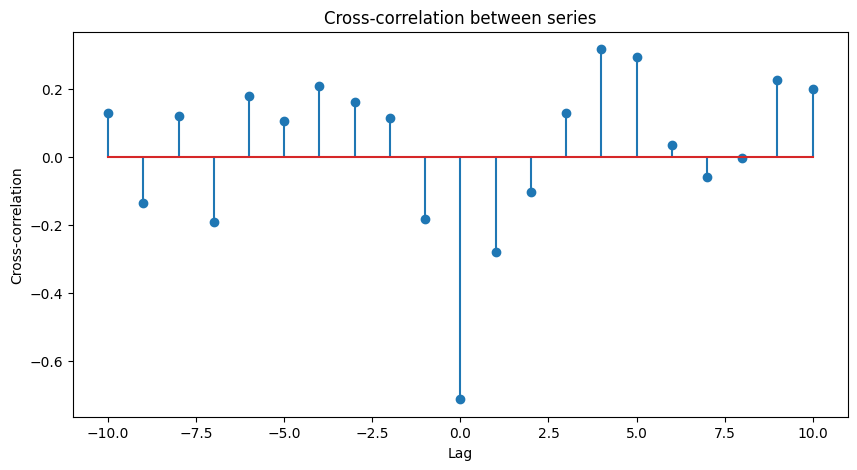

In [12]:
cross_correlation_values = cross_correlation(quarterly_data['d_cost'], quarterly_data['d_ln_open_price'], lag=10)

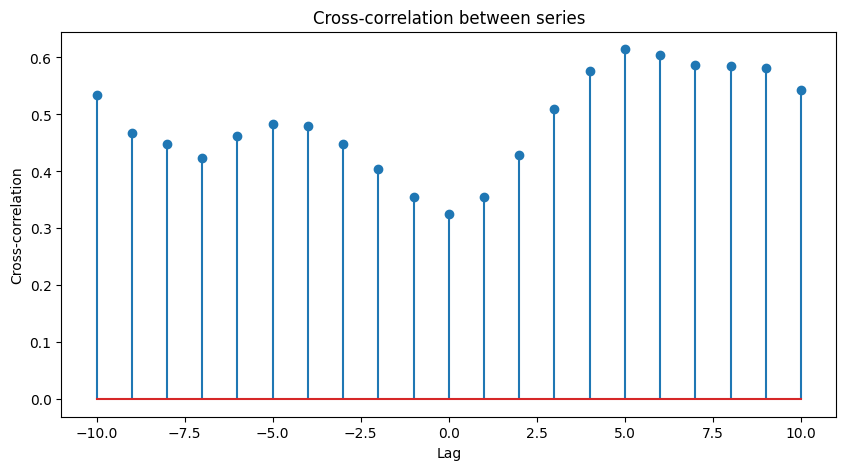

In [13]:
cross_correlation_values = cross_correlation(quarterly_data['cost'], quarterly_data['ln_open_price'], lag=10)

# Monthly

Monthly Data Model Estimation:
p: 1, q: 1, end: 94
p: 1, q: 1, end: 95
p: 1, q: 1, end: 96
p: 1, q: 1, end: 97
p: 1, q: 1, end: 98
p: 1, q: 1, end: 99
p: 1, q: 1, end: 100
p: 1, q: 1, end: 101
p: 1, q: 1, end: 102
p: 1, q: 1, end: 103
p: 1, q: 1, end: 104
p: 1, q: 1, end: 105
rolling_mse
[0.000225364399688905, 0.09789867748168879, 0.20462192177825567, 0.00024235406187552347, 0.051756317070387664, 0.020371403057168194, 0.08626281155911439, 0.000791217094085528, 0.012885545220969073, 0.15641424178534774, 0.08434133166337345, 0.08061583886162604]
p: 1, q: 2, end: 94
p: 1, q: 2, end: 95
p: 1, q: 2, end: 96
p: 1, q: 2, end: 97
p: 1, q: 2, end: 98
p: 1, q: 2, end: 99
p: 1, q: 2, end: 100
p: 1, q: 2, end: 101
p: 1, q: 2, end: 102
p: 1, q: 2, end: 103
p: 1, q: 2, end: 104
p: 1, q: 2, end: 105
rolling_mse
[0.0029123434886289424, 0.09871735007168742, 0.2149610564851476, 0.004997230791441971, 0.08473532274264844, 0.010149049744086862, 0.07934172953280111, 0.0014966102459368095, 0.0065332771265986

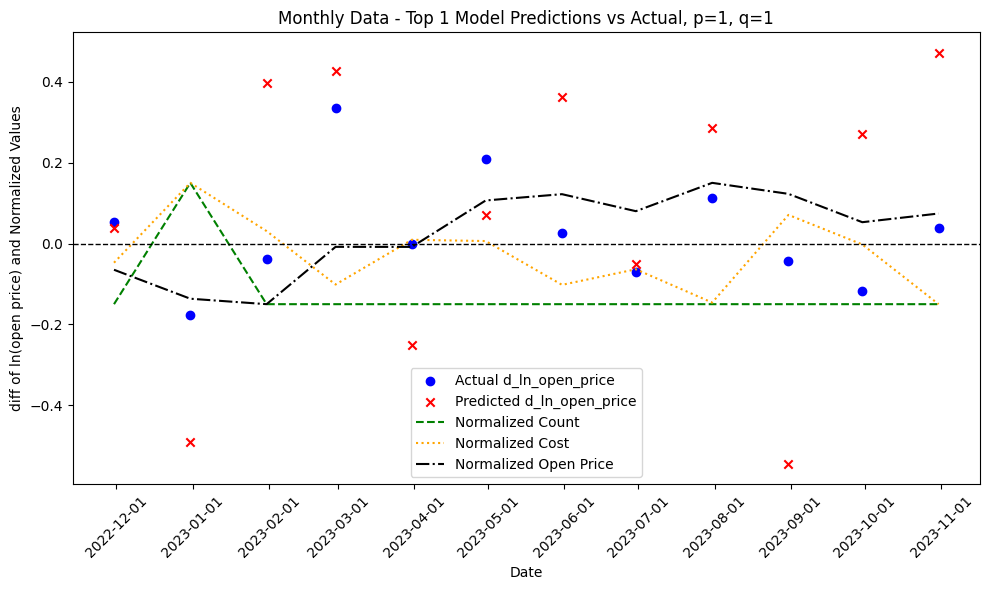

Top 2 Model: ARIMA(5,0,3), MSE: 0.06813261129355698
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                  105
Model:                 ARIMA(5, 0, 3)   Log Likelihood                  37.834
Date:                Wed, 27 Mar 2024   AIC                            -51.667
Time:                        08:39:58   BIC                            -19.819
Sample:                    01-31-2015   HQIC                           -38.762
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0430      0.048      0.896      0.370      -0.051       0.137
cost           0.0099      0.230      0.043      0.966      -0.440       0.460


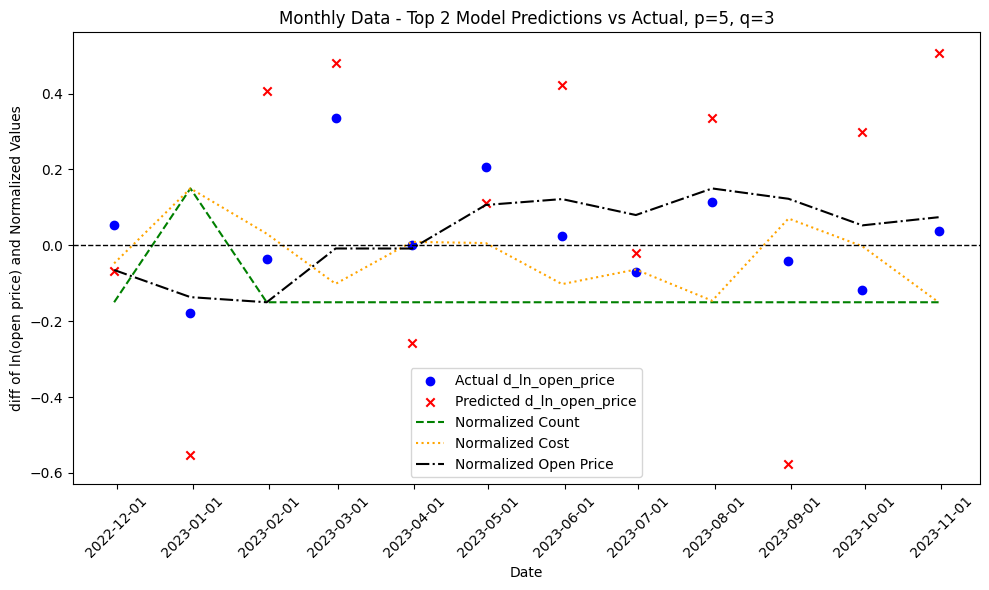

Top 3 Model: ARIMA(2,0,2), MSE: 0.06853892665301513
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                  105
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  36.767
Date:                Wed, 27 Mar 2024   AIC                            -57.534
Time:                        08:39:13   BIC                            -36.302
Sample:                    01-31-2015   HQIC                           -48.930
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0423      0.030      1.413      0.158      -0.016       0.101
cost           0.0581      0.149      0.390      0.696      -0.234       0.350


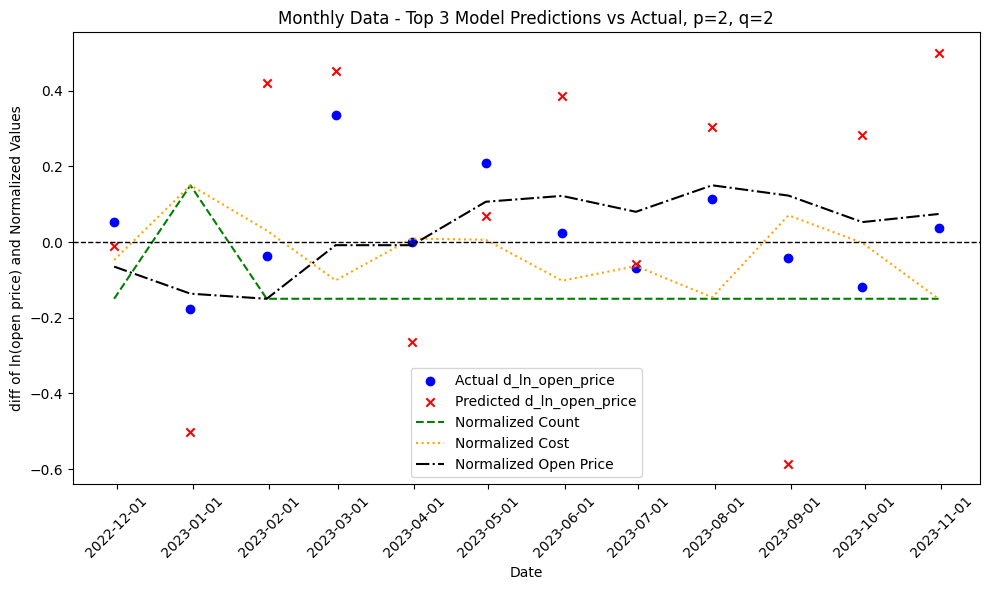

In [36]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(1, 6, 1), range(1, 6, 1), title='Monthly Data', eval_size=12)
results_df

In [ ]:
exploratory_analysis(monthly_data)

# Weekly

In [37]:
print("Weekly Data Model Estimation:")
model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', eval_size=55)
# model_estimation(weekly_data, range(1, 4, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

Weekly Data Model Estimation:
p: 1, q: 1, end: 402
p: 1, q: 1, end: 403
p: 1, q: 1, end: 404
p: 1, q: 1, end: 405
p: 1, q: 1, end: 406
p: 1, q: 1, end: 407
p: 1, q: 1, end: 408
p: 1, q: 1, end: 409
p: 1, q: 1, end: 410
p: 1, q: 1, end: 411
p: 1, q: 1, end: 412
p: 1, q: 1, end: 413
p: 1, q: 1, end: 414
p: 1, q: 1, end: 415
p: 1, q: 1, end: 416
p: 1, q: 1, end: 417
p: 1, q: 1, end: 418
p: 1, q: 1, end: 419
p: 1, q: 1, end: 420
p: 1, q: 1, end: 421
p: 1, q: 1, end: 422
p: 1, q: 1, end: 423
p: 1, q: 1, end: 424
p: 1, q: 1, end: 425
p: 1, q: 1, end: 426
p: 1, q: 1, end: 427
p: 1, q: 1, end: 428
p: 1, q: 1, end: 429
p: 1, q: 1, end: 430
p: 1, q: 1, end: 431
p: 1, q: 1, end: 432
p: 1, q: 1, end: 433
p: 1, q: 1, end: 434
p: 1, q: 1, end: 435
p: 1, q: 1, end: 436
p: 1, q: 1, end: 437
p: 1, q: 1, end: 438
p: 1, q: 1, end: 439
p: 1, q: 1, end: 440
p: 1, q: 1, end: 441
p: 1, q: 1, end: 442
p: 1, q: 1, end: 443
p: 1, q: 1, end: 444
p: 1, q: 1, end: 445
p: 1, q: 1, end: 446
p: 1, q: 1, end: 447
p: 1

In [ ]:
exploratory_analysis(weekly_data)

# Daily

In [ ]:
print("Daily Data Model Estimation:")
# model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

In [ ]:
exploratory_analysis(daily_data)